In [1]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from src import download as D

In [2]:
downloader = D.downloader("./data")

# downloader.data_download("temperatures.csv", "https://stdatalake009.blob.core.windows.net/public/temperatures.csv")

In [3]:
dataset = pd.read_csv("./data/RAW/temperatures.csv")
dataset = dataset[["Region","Country","Month","Day","Year","AvgTemperature"]][dataset["Year"] != 2020]
dataset = dataset[["Region","Country","Month","Day","Year","AvgTemperature"]][dataset["AvgTemperature"] != -99]
dataset["AvgTemperatureC"] = (dataset["AvgTemperature"]-32) * 5/9

# Analyse de la température moyenne en France de 1995 à 2019

In [4]:
dataset_france = dataset[["Month","Day","Year","AvgTemperatureC"]][dataset["Country"].str.contains("France")]

In [5]:
temp_moy_france = dataset_france.groupby(["Year"])["AvgTemperatureC"].mean()

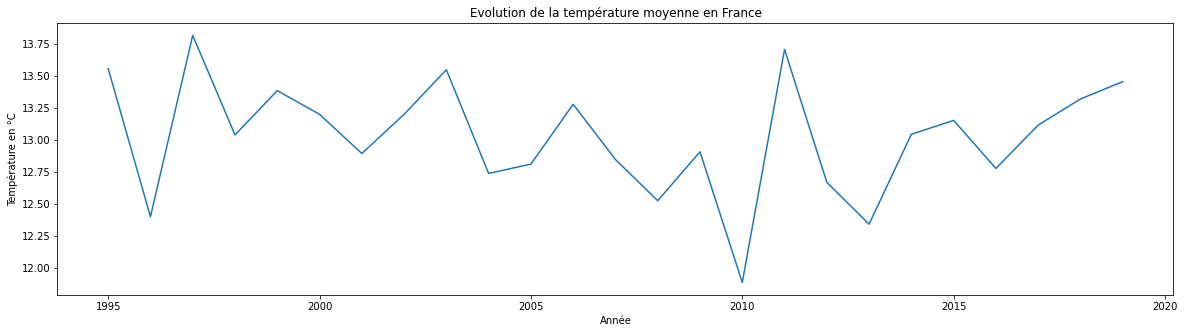

In [6]:
plt.figure(figsize=(20,5))
plt.plot(temp_moy_france) 
plt.title("Evolution de la température moyenne en France")
plt.ylabel("Température en °C")
plt.xlabel("Année")


del temp_moy_france

# Analyse de la température moyenne par mois et par région entre 1995 et 2019

In [7]:
dataset_moy = dataset.groupby(["Region","Month"])["AvgTemperatureC"].mean().reset_index()

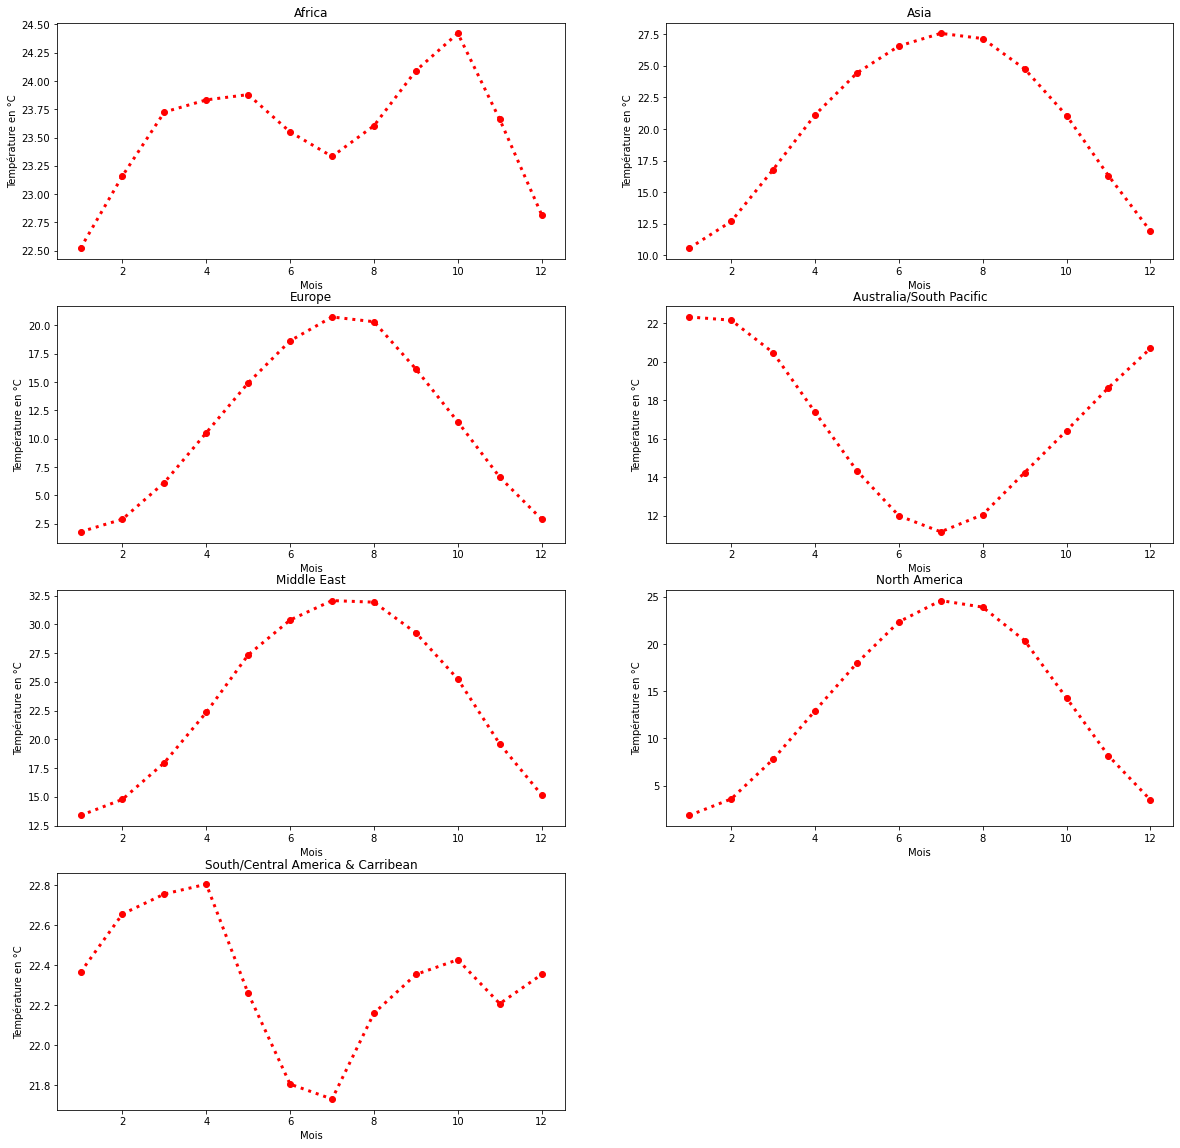

In [8]:
plt.figure(figsize=(20,20))
plt.subplot(4,2,1)
plt.plot(dataset_moy[["Month"]][dataset_moy["Region"].str.contains("Africa")], dataset_moy[["AvgTemperatureC"]][dataset_moy["Region"].str.contains("Africa")],c="red", lw=3, ls=":", marker="o")
plt.title("Africa")
plt.ylabel("Température en °C")
plt.xlabel("Mois")

plt.subplot(4,2,2)
plt.plot(dataset_moy[["Month"]][dataset_moy["Region"].str.contains("Asia")], dataset_moy[["AvgTemperatureC"]][dataset_moy["Region"].str.contains("Asia")],c="red", lw=3, ls=":", marker="o")
plt.title("Asia")
plt.ylabel("Température en °C")
plt.xlabel("Mois")

plt.subplot(4,2,3)
plt.plot(dataset_moy[["Month"]][dataset_moy["Region"].str.contains("Europe")], dataset_moy[["AvgTemperatureC"]][dataset_moy["Region"].str.contains("Europe")],c="red", lw=3, ls=":", marker="o")
plt.title("Europe")
plt.ylabel("Température en °C")
plt.xlabel("Mois")

plt.subplot(4,2,4)
plt.plot(dataset_moy[["Month"]][dataset_moy["Region"].str.contains("Australia/South Pacific")], dataset_moy[["AvgTemperatureC"]][dataset_moy["Region"].str.contains("Australia/South Pacific")],c="red", lw=3, ls=":", marker="o")
plt.title("Australia/South Pacific")
plt.ylabel("Température en °C")
plt.xlabel("Mois")

plt.subplot(4,2,5)
plt.plot(dataset_moy[["Month"]][dataset_moy["Region"].str.contains("Middle East")], dataset_moy[["AvgTemperatureC"]][dataset_moy["Region"].str.contains("Middle East")],c="red", lw=3, ls=":", marker="o")
plt.title("Middle East")
plt.ylabel("Température en °C")
plt.xlabel("Mois")

plt.subplot(4,2,6)
plt.plot(dataset_moy[["Month"]][dataset_moy["Region"].str.contains("North America")], dataset_moy[["AvgTemperatureC"]][dataset_moy["Region"].str.contains("North America")],c="red", lw=3, ls=":", marker="o")
plt.title("North America")
plt.ylabel("Température en °C")
plt.xlabel("Mois")

plt.subplot(4,2,7)
plt.plot(dataset_moy[["Month"]][dataset_moy["Region"].str.contains("South/Central America & Carribean")], dataset_moy[["AvgTemperatureC"]][dataset_moy["Region"].str.contains("South/Central America & Carribean")],c="red", lw=3, ls=":", marker="o")
plt.title("South/Central America & Carribean")
plt.ylabel("Température en °C")
plt.xlabel("Mois")


del dataset_moy

# Classement des pays les plus chauds entre 1995 et 2019

In [9]:
dataset_top_chauds = dataset.groupby(["Country"])["AvgTemperatureC"].mean().sort_values(ascending=False).reset_index()

Text(0.5, 0, 'Pays')

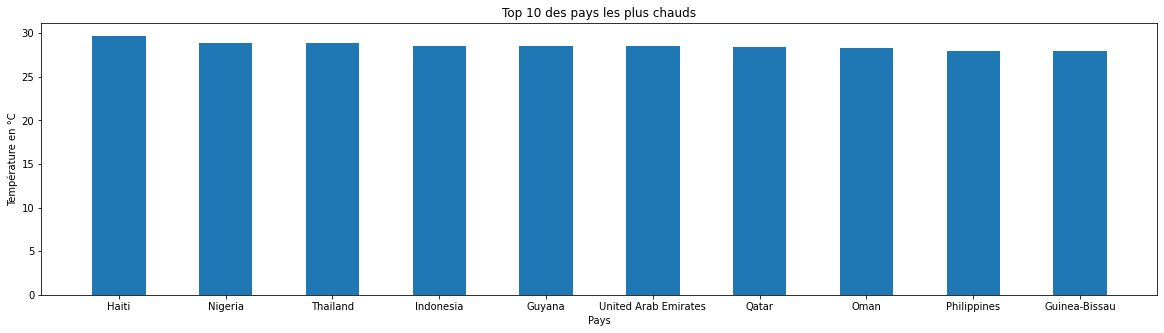

In [10]:
plt.figure(figsize=(20,5))
plt.bar(dataset_top_chauds["Country"][0:10], dataset_top_chauds["AvgTemperatureC"][0:10],  width=0.5)
plt.title("Top 10 des pays les plus chauds")
plt.ylabel("Température en °C")
plt.xlabel("Pays")

# Classement des pays les plus froids entre 1995 et 2019

In [11]:
dataset_top_froids = dataset.groupby(["Country"])["AvgTemperatureC"].mean().sort_values(ascending=True).reset_index()

Text(0.5, 0, 'Pays')

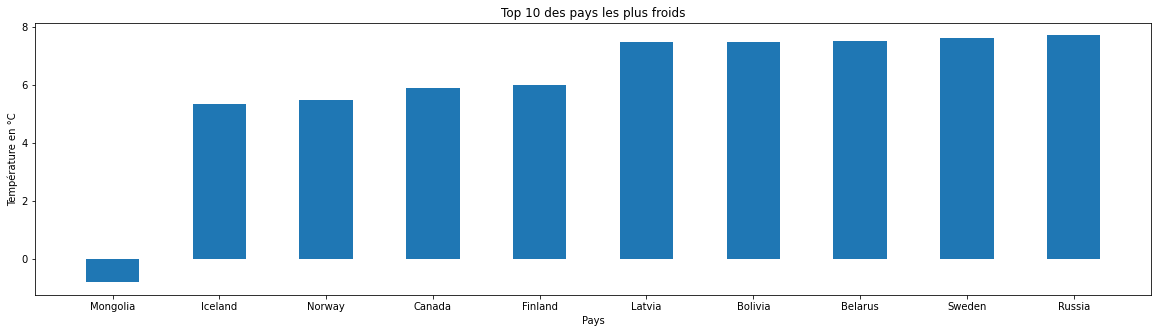

In [12]:
plt.figure(figsize=(20,5))
plt.bar(dataset_top_froids["Country"][0:10], dataset_top_froids["AvgTemperatureC"][0:10],  width=0.5)
plt.title("Top 10 des pays les plus froids")
plt.ylabel("Température en °C")
plt.xlabel("Pays")

# Evolution des températures entre le pays le plus froid et le pays le plus chaud, entre 1995 et 2019

In [16]:
data_froid = dataset[["Year", "AvgTemperatureC"]][dataset["Country"].str.contains(dataset_top_froids["Country"][0])].groupby(["Year"])["AvgTemperatureC"].mean().reset_index()
pays_froid = dataset_top_froids["Country"][0]
data_chaud = dataset[["Year", "AvgTemperatureC"]][dataset["Country"].str.contains(dataset_top_chauds["Country"][0])].groupby(["Year"])["AvgTemperatureC"].mean().reset_index()
pays_chaud = dataset_top_chauds["Country"][0]

Text(0.5, 0, 'Années')

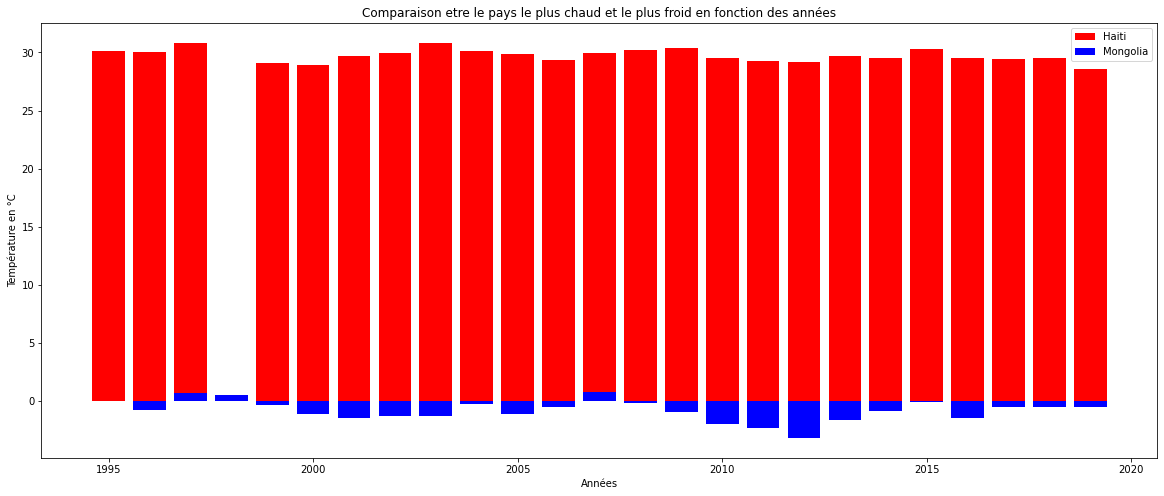

In [19]:
plt.figure(figsize=(20,8))
plt.bar(data_chaud["Year"], data_chaud["AvgTemperatureC"], color="red", label=pays_chaud)
plt.bar(data_froid["Year"], data_froid["AvgTemperatureC"], color="blue", label=pays_froid)
plt.legend()
plt.title("Comparaison etre le pays le plus chaud et le plus froid en fonction des années")
plt.ylabel("Température en °C")
plt.xlabel("Années")